# Classification with an AdaBoost Boosted Decision Tree (BDT)
 > **Created**:  October 8 2022 ASP 2022 South Africa, Harrison B. Prosper<br>
> **Updated**: Adapted for AEPSHEP 2024, June 22 2024, Thailand<br>
 > ATLAS Open Data

## Task
Discriminate between Higgs boson events produced via vector-boson fusion from events produced via gluon-gluon fusion using the di-jet mass $m_{jj}$ (massjj) and the di-jet separation $|\Delta\eta_{jj}|$ (detajj) in pseudo-rapidity.

## AdaBoost Algorithm

Boosting is a class of algorithms for creating high-performance models from many **weak learners**, that is,  weakly-performing models. The first successful boosting algorithm, **AdaBoost**,  for classification using decision trees was published in 1997 by Freund and Scapire[1] and proved to be a significant breakthrough. Here is the pseudo-code for the algorithm, where $\text{f\_k(x)} \equiv f_k(x)$ is a **decision tree**, t\_n are the targets, x\_n are the inputs to the decision tree, w\_n are the event (or object) weights, and $N$ is the data sample size:
```python
given training data T = {(t_n, x_n, w_n)}, n = 1,...,N
    initialize event weights to w_n = 1/N, n = 1,...,N
    
    for k = 1 to K
        create             f_k(x) using weighted data T
        apply              f_k(x) to T
        compute error rate e_k using T
        compute            a_k = ln[(1-e_k)/e_k]
        compute            w_n = w_n * exp(-a_k * t_n * f_k(x_n)), n = 1,...,N
        normalize          w = w / sum_n(w)

    BDT(x) = sum_k(a_k * f_k(x))
```
Three years after the AdaBoost paper it was shown[2] that this rather cryptic algorithm is exactly equivalent to minimizing the average of the exponential loss
\begin{align}
    L(t, f) & = \exp(-t \, f(x)),
\end{align}
and that the function $\text{BDT}(x)$, for a balanced dataset (that is, with equal priors $\pi(t=+1) = \pi(t=-1)$), approximates
\begin{align}
    \text{BDT}(x) & = \frac{1}{2} \log \left[\frac{p(x | t = +1)}{p(x | t = -1)} \right] ,
\end{align}
which can be transformed to
\begin{align}
    p(x | t = +1) & = \text{logistic}(\, 2 \, \text{BDT}(x)\, ), \\
                & = \frac{1}{1 + \exp(-2 \, \text{BDT}(x))} .
\end{align}

## References
  1. Y. Freund and R.E. Schapire. Journal of Computer and  Sys. Sci. 55 (1), 119 (1997).
  2. J. Friedman, T. Hastie and R. Tibshirani, “Additive logistic regression: a statistical view of boosting,” The Annals of Statistics, 28(2), 377-386, (2000).

In [1]:
import os, sys
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text

# standard measures of model performance
from sklearn.metrics import roc_curve, auc

#import joblib as jb
import matplotlib as mp
import matplotlib.pyplot as plt
%matplotlib inline

#import importlib

# update fonts
FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

### Load $4\ell$ ATLAS Open Data 

In [2]:
train = pd.read_csv('../datasets/atlas_opendata_4l_train.csv.gz')
test  = pd.read_csv('../datasets/atlas_opendata_4l_test.csv.gz')
test[:5]

,mass4l,detajj,massjj,target
0,121.788477,4.155531,814.198138,1
1,125.814360,3.432720,293.062246,1
2,119.421988,3.176038,187.240780,-1
3,119.961254,0.304112,42.068307,-1
4,119.280590,4.329558,890.590023,1


Count how many VBF events we have in the samples. Should be balanced samples.

In [3]:
((train['target'] < 0.5).sum(), (train['target'] > 0.5).sum(),
 (test['target']  < 0.5).sum(),  (test['target'] > 0.5).sum())

(25000, 25000, 2500, 2500)

In [4]:
XNAME = 'detajj'; XLABEL = r'$|\Delta\eta_{jj}|$'
YNAME = 'massjj'; YLABEL = r'$m_{jj}$ (GeV)'

XBINS =   5
XMIN  =   0
XMAX  =   5
XSTEP =   1

YBINS =   5
YMIN  =   0
YMAX  =1000
YSTEP = 200

inputs= [XNAME, YNAME]

train_x = train[inputs]
print(len(train_x))
train_y = train['target']

test_x  = test[inputs]
print(len(test_x))
test_y  = test['target']

train_x[:5]

50000
5000


,detajj,massjj
0,0.568247,25.554900
1,0.242446,913.958843
2,3.151283,280.493217
3,0.959159,115.645538
4,0.484256,182.758932


### Approximate $p(y = 1| x)$ by histogramming

__Note__:
    
  * $x = (m_{jj}, |\Delta\eta_{jj}|)$
  * $y = 1$ for VBF events, $y = -1$ for ggf events

In [5]:
# split into signal and background events
sig = train[train['target'] > 0.5]
bkg = train[train['target'] < 0.5]

s, xedges, yedges = np.histogram2d(sig[XNAME], sig[YNAME], 
                                   bins=(XBINS, YBINS), 
                          range=((XMIN, XMAX), (YMIN, YMAX)))

b, xedges, yedges = np.histogram2d(bkg[XNAME], bkg[YNAME], 
                                   bins=(XBINS, YBINS), 
                          range=((XMIN, XMAX), (YMIN, YMAX)))

x = (xedges[:-1]+xedges[1:])/2
y = (yedges[:-1]+yedges[1:])/2
x, y = np.meshgrid(x, y)

# WARNING: must transpose z so that x, y, and z have the
# same shape
d = np.where(s + b <= 0, 1e10, s + b)

# z = p(y=1|data)
z = s / d
H = (x, y, z.T)

# choose a subset
K = 8000
t = test[:K]
sig = t[t['target'] > 0]
bkg = t[t['target'] < 0]
print(len(sig), len(bkg), len(sig)+len(bkg))

2500 2500 5000


### Plot contours of $p(y = 1| x)$, where $x = (m_{jj}, |\Delta\eta_{jj}|)$

histogram(a, bins=10, range=None, normed=None, weights=None, density=None)

In [6]:
def plot_data(sig, bkg, h=None,
              xname=XNAME, yname=YNAME, 
              xlabel=XLABEL, ylabel=YLABEL,
              xmin=XMIN, xmax=XMAX, xstep=XSTEP,
              ymin=YMIN, ymax=YMAX, ystep=YSTEP, 
              filename='hzz4l_sig_vs_bkg.png',
              fgsize=(5, 5), 
              alpha=0.5,
              contour_colors='rainbow',
              bdt_colors='gist_earth',
              ftsize=FONTSIZE, 
              bdt=None):
    
    # make room for 1 sub-plot
    fig, ax = plt.subplots(nrows=1, 
                            ncols=1, 
                            figsize=fgsize)
    
    # annotate axes
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(xlabel, fontsize=ftsize)
    ax.set_xticks(np.arange(xmin, xmax+xstep, xstep))
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=ftsize)
    ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
     
    ax.scatter(sig[xname], sig[yname], marker='o',
                s=20, c='blue', alpha=alpha, label='vbf')
    ax.legend(loc='upper left') # activate legend
    
    ax.scatter(bkg[xname], bkg[yname], marker='*',
                s=10, c='red',  alpha=alpha, label='ggf')
  
    # optional add BDT bins
    if bdt:
        bdt.plot2D(itree, ax, 
                   colormap=bdt_colors, 
                   alpha=alpha)
    else:
        ax.grid()
        
    if h:
        x, y, z = h
        mylevels = np.arange(0.1, 1, 0.1) 
        cs = ax.contour(x, y, z, 
               extent=(xmin, xmax, ymin, ymax),
               levels=mylevels,
               linewidths=2,
               cmap=contour_colors)
    
        ax.clabel(cs, cs.levels, inline=True, 
              fontsize=20, fmt='%3.1f', 
              colors='black')
          
    ax.legend(loc='upper left') # activate legend

    print(filename)
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

hzz4l_detajj_massjj.png


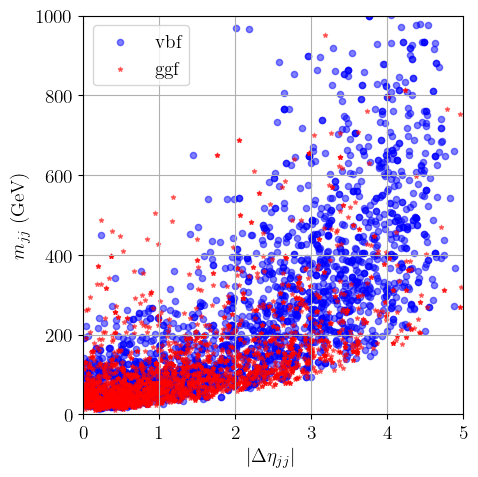

hzz4l_detajj_massjj_with_contours.png


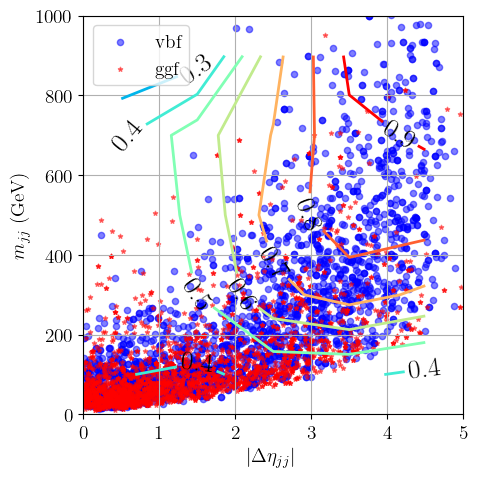

In [7]:
plot_data(sig, bkg, 
          filename='hzz4l_%s_%s.png' % (XNAME, YNAME),
          contour_colors='Blues')

plot_data(sig, bkg, H,
          filename='hzz4l_%s_%s_with_contours.png' % (XNAME, YNAME),
          contour_colors='rainbow')

### Train classifier

In [8]:
bdt = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=5), #min_samples_leaf=800),                
                         algorithm="SAMME", 
                         n_estimators=25)

print("Training...")
bdt.fit(train_x, train_y)

print("Training set score: %10.3f" % bdt.score(train_x, train_y))      
print("Test set score:     %10.3f" % bdt.score(test_x,  test_y))

Training...
Training set score:      0.650
Test set score:          0.651


### Load BDT wrapper class 

This Python class was adapted from one developed for TMVA many years ago.


tree number 5	weight =  1.366e-01
   ROOT      massjj     465.47
  -- LEFT      massjj     141.83
  ---- LEFT      massjj      78.85
  ------ LEFT      massjj      64.24
  -------- LEFT      massjj      62.32
  ---------- LEFT  SIG   1.41e-01   1.43e-01       1.00
  ---------- RIGHT SIG   5.17e-03   6.87e-03       1.00
  -------- RIGHT     detajj       0.13
  ---------- LEFT  BKG   3.90e-03   2.20e-03      -1.00
  ---------- RIGHT BKG   3.94e-02   3.47e-02      -1.00
  ------ RIGHT     detajj       2.58
  -------- LEFT      massjj      79.16
  ---------- LEFT  SIG   3.80e-04   1.31e-03       1.00
  ---------- RIGHT SIG   9.39e-02   1.15e-01       1.00
  -------- RIGHT     detajj       3.54
  ---------- LEFT  BKG   1.23e-02   8.79e-03      -1.00
  ---------- RIGHT BKG   3.60e-04   0.00e+00      -1.00
  ---- RIGHT     detajj       2.28
  ------ LEFT      massjj     191.28
  -------- LEFT      detajj       2.26
  ---------- LEFT  BKG   3.10e-02   2.93e-02      -1.00
  ---------- RIGHT BK

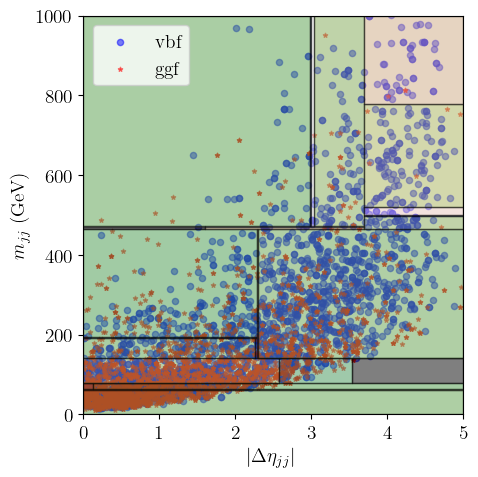

In [9]:
import bdtutil as bd
#import ROOT

bdtree = bd.BDT(bdt)

itree  = 5
bdtree.printTree(itree)

plot_data(sig, bkg,
          fgsize=(5, 5),
          filename=f'hzz4l_%s_%s_tree{itree:d}.png' % (XNAME, YNAME), 
          bdt=bdtree, 
          bdt_colors='gist_earth')

In [10]:
def plot_trees(bdt, 
               xname=XNAME, yname=YNAME, 
               xlabel=XLABEL, ylabel=YLABEL,
               xmin=XMIN, xmax=XMAX, xstep=XSTEP,
               ymin=YMIN, ymax=YMAX, ystep=YSTEP, 
               filename='hzz4l_trees.png',
               fgsize=(9, 6), 
               alpha=0.5, colormap='gist_earth',
               ftsize=FONTSIZE):
    
    # make room for 6 sub-plots
    n_rows = 2
    n_cols = 3
    fig, axs = plt.subplots(nrows=n_rows, 
                            ncols=n_cols, 
                            figsize=fgsize)

    
    kk =-1
    for ii, ax in enumerate(axs.flatten()):
        jj = ii % n_cols
        if jj == 0:
            kk += 1
            
        # annotate axes
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        
        if jj == 0:
            ax.set_ylabel(ylabel, fontsize=ftsize)
            ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
            
        if kk+1 == n_rows:
            ax.set_xlabel(xlabel, fontsize=ftsize)
            ax.set_xticks(np.arange(xmin, xmax+xstep, xstep))
    
        bdt.plot2D(ii, ax, 
                   colormap=colormap, 
                   alpha=alpha)
    
    print(filename)
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

hzz4l_trees.png


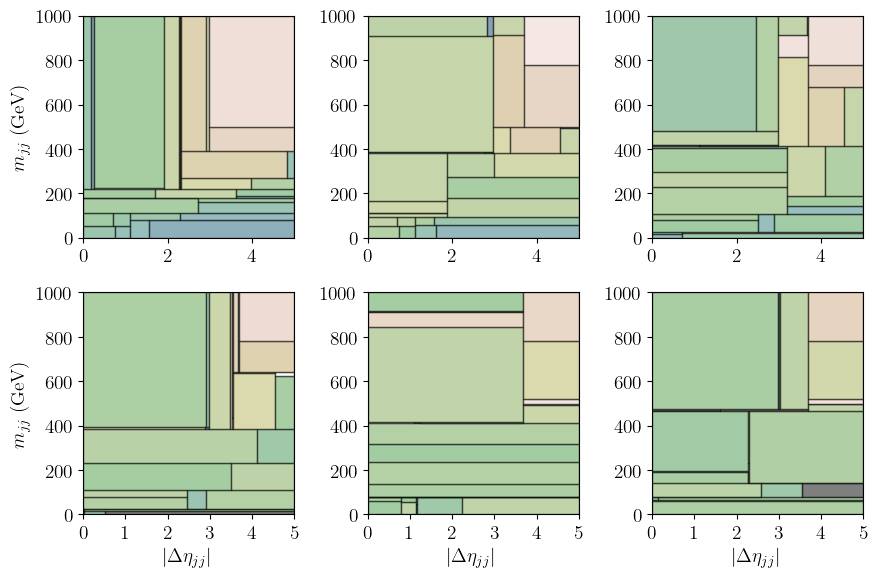

In [11]:
plot_trees(bdtree, colormap='gist_earth')

### Compare calculations between bdtree and (scikit-learn) bdt (scikit-learn)

**Warning** For the AdaBoost algorithm, $\text{skikit-learn}$ defines, *incorrectly*, the BDT (whose value is returned by the method $d(x) = bdt.\texttt{decision\_function}(x)$) as
$$\text{BDT}(x) = 2 \sum_{k=1}^K \alpha_k^\prime \, f_k(x), \quad \alpha_k^\prime = \frac{\alpha_k}{\sum_{j=1}^K \alpha_j} ,$$
and the $\texttt{predict\_proba}(x)$ is computed as
$$p(x | t = +1) = \texttt{logistic}(\text{BDT}(x)).$$
The calculation would be correct if the coefficients $\alpha_k$ were left *unnormalized* and the factor of 2 scaled the BDT in the logistic function. Below we compute the decision function (that is, the BDT) and the associated class probability (for a balanced data sample) using the incorrect and correct calculation.

In [12]:
x   = test_x[:10]
print(x)
print()

print('using scikit-learn definition of decision function')
print('%12s %12s\t%12s %12s' % \
      ('bdt', 'bdt_skl', 'bdt(p)', 'bdt_skl(p)'))

Y1  = bdtree.decision_function(x, like_scikit_learn=True)
P1  = bdtree.predict_proba(x, like_scikit_learn=True)

Y2  = bdt.decision_function(x)
P2  = bdt.predict_proba(x).T[-1]

for y1, y2, p1, p2 in zip(Y1, Y2, P1, P2):
    print('%12.5f %12.5f\t%12.5f %12.5f' % \
          (y1, y2, p1, p2))
print()
print('using correct definition of decision function')
print('%12s %12s' % ('bdt', 'bdt_skl(p)'))

Y1  = bdtree.decision_function(x)
P1  = bdtree.predict_proba(x)

for y1, p1 in zip(Y1, P1):
    print('%12.5f %12.5f' % (y1, p1))

     detajj      massjj
0  4.155531  814.198138
1  3.432720  293.062246
2  3.176038  187.240780
3  0.304112   42.068307
4  4.329558  890.590023
5  0.434336  147.711852
6  2.069314  236.763752
7  3.926730  753.524053
8  1.827156  202.609735
9  2.044817  105.590852

using scikit-learn definition of decision function
         bdt      bdt_skl	      bdt(p)   bdt_skl(p)
     1.77317      1.77317	     0.85485      0.85485
     0.95116      0.95116	     0.72135      0.72135
     0.32391      0.32391	     0.58028      0.58028
    -0.32092     -0.32092	     0.42045      0.42045
     2.00000      2.00000	     0.88080      0.88080
    -0.06695     -0.06695	     0.48327      0.48327
     0.49447      0.49447	     0.62116      0.62116
     1.64434      1.64434	     0.83812      0.83812
     0.86212      0.86212	     0.70310      0.70310
    -0.17592     -0.17592	     0.45613      0.45613

using correct definition of decision function
         bdt   bdt_skl(p)
     2.30185      0.99008
     1.23475 

### Plot contours of constant signal probability

As noted in the introduction, **AdaBoost** is equivalent to an algorithm that minimizes the average exponential loss, $L = \exp(-t\, f),$ where the targets are $t = -1$ for background and $t = +1$ for signal. Minimizing the average loss (for an infinite amount of data) leads to 
\begin{align}
    \int \frac{\partial L}{\partial f} \, p(t | x) \, dt & = 0,
\end{align}
which must be solved to determine the mathematical expression approximated by the model $f(x, \omega)$ with free parameters $\omega$. When the above is solved for the exponential loss one concludes that the best fit model, $\hat{f}$ (determined with a finite data sample), approximates the optimal model 
\begin{align}
    f^*(x) \equiv \text{BDT}(x) & = \frac{1}{2} \ln \frac{p(t = +1 | x)}{p(t = -1| x)} ,
\end{align}
which can be rearranged as
\begin{align}
    p(t = +1 | x) & = \text{logistic}(2 \, \text{BDT}(x)),\\
    & = \frac{1}{1 + \exp(-2 \, \text{BDT}(x))},\\
    & = \frac{p(x | t = +1) \, \epsilon}{p(x | t = +1) \, \epsilon + p(x | t = -1) } ,
\end{align}
where $\epsilon = \pi(t = +1) \, / \, \pi(t = -1)$ is the prior signal to background ratio. For a balanced data sample, $\epsilon = 1$ in which case,
\begin{align}
    \text{BDT(x)} & = \frac{1}{2} \ln \frac{p(x | t = +1 )}{p(x | t = -1)} .
\end{align}

In [13]:
def plot_contours(bdtree, sig, bkg, h=None, 
                  add_bdt_contours=False,
                  colormap='gist_earth',
                  numTrees=-1, 
                  xname=XNAME, yname=YNAME, 
                  xlabel=XLABEL, ylabel=YLABEL,
                  xmin=XMIN, xmax=XMAX, xstep=XSTEP,
                  ymin=YMIN, ymax=YMAX, ystep=YSTEP,
                  fgsize=(6, 5), 
                  alpha=0.5,
                  ftsize=FONTSIZE, 
                  filename='hzz4l_forest.png'):
    
    # make room for 1 sub-plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=fgsize)

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # annotate axes
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(xlabel, fontsize=ftsize)
    ax.set_xticks(np.arange(xmin, xmax+xstep, xstep))
    
    ax.set_ylim(ymin, ymax)
    ax.set_ylabel(ylabel, fontsize=ftsize)
    ax.set_yticks(np.arange(ymin, ymax+ystep, ystep))
    
    ax.scatter(sig[xname], sig[yname], marker='o',
                s=20, c='blue', alpha=alpha, label='vbf')
    ax.legend(loc='upper left') # activate legend
    
    ax.scatter(bkg[xname], bkg[yname], marker='*',
                s=10, c='red',  alpha=alpha, label='ggF')
    ax.legend(loc='upper left') # activate legend
    
    # superimpose a BDT contour plot
    # 1. first create a meshgrid
    # 2. compute network output at all mesh points
    npoints= 200
    xdelta = float(xmax-xmin)/npoints
    ydelta = float(ymax-ymin)/npoints
    xx     = np.arange(xmin, xmax, xdelta)
    yy     = np.arange(ymin, ymax, ydelta)
    X, Y   = np.meshgrid(xx, yy)
    
    # compute model probability at every grid point
    # then reshape to an (npoints x npoints) array
    df = pd.DataFrame({xname: X.flatten(), yname: Y.flatten()})
    
    Z  = bdtree.predict_proba(df, numTrees).reshape([npoints, npoints])

    plt.imshow(Z, origin='lower', aspect='auto', 
               extent=(xmin, xmax, ymin, ymax), 
               cmap=colormap)
    plt.colorbar()
    
    mylevels = np.arange(0.1, 1, 0.1) 
    
    if add_bdt_contours:
        npoints= 10
        xdelta = float(xmax-xmin)/npoints
        ydelta = float(ymax-ymin)/npoints
        xx     = np.arange(xmin, xmax, xdelta)
        yy     = np.arange(ymin, ymax, ydelta)
        X2, Y2 = np.meshgrid(xx, yy)
        df     = pd.DataFrame({xname: X2.flatten(), yname: Y2.flatten()})
        
        Z2  = bdtree.predict_proba(df, numTrees,
                                   like_scikit_learn=False).reshape([npoints, 
                                                          npoints])

        cs = ax.contour(X2, Y2, Z2, 
               extent=(xmin, xmax, ymin, ymax),
               levels=mylevels,
               linewidths=2,
               linestyles='dashed',
               cmap='rainbow_r')
    
    if h:
        x, y, z = h
        cs = ax.contour(x, y, z, 
               extent=(xmin, xmax, ymin, ymax),
               levels=mylevels,
               linewidths=2,
                    cmap='Blues')
    
        ax.clabel(cs, cs.levels, inline=True, 
              fontsize=20, fmt='%3.1f', 
              colors='black')

    print(filename)
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

One sees that the boosted decision tree agrees with the probability contours approximated by histogramming.

hzz4l_forest.png


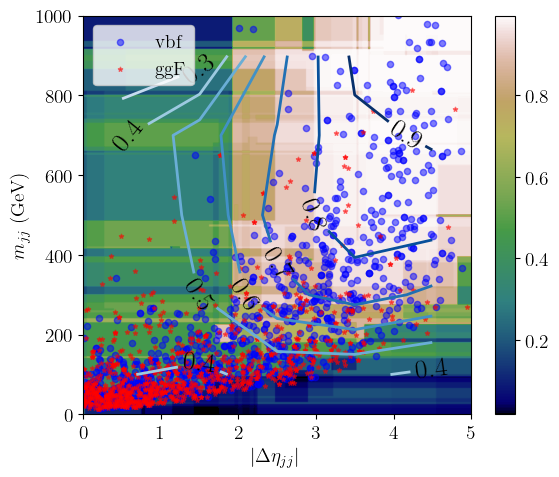

In [14]:
K = 1000
plot_contours(bdtree, sig[:K], bkg[:K], h=H,
              add_bdt_contours=False,
              colormap='gist_earth')